In [4]:
import os

import tqdm
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn

import vari
import vari.datasets
import vari.models
import vari.inference

from vari.layers import GaussianLayer, BernoulliLayer

from sklearn.datasets import make_circles

In [5]:
experiments_dir = '/nas/experiments/sacred/models/'
mpl.style.use('default')

In [6]:
def get_constant_colormap(rgb_color):
    # Colormap that is constant at the given rgb_color.
    r, g, b = rgb_color
    cdict = {'red': [(0, r, r), (1, r, r)], 
             'green': [(0, g, g), (1, g, g)],
             'blue': [(0, b, b), (1, b, b)]}
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

## Select models and data

In [207]:
run_ids_moons = {
    'VAE 1L 5IS': 6694,
    'VAE 1L 100IS': 6697,
    'VAE 2L 5IS': 6695,
    'VAE 2L 100IS': 6696,
}
run_ids_moons = {
    'VAE 1L 5IS': 6708,
    'VAE 2L 5IS': 6707,
}
run_ids_moons = {
    'VAE 1L 100IS σ=0.05': 6711,
    'VAE 2L 100IS σ=0.05': 6710,
}
run_ids_moons = {
    'VAE 1L 5IS σ=0.01': 6713,
    'VAE 2L 5IS σ=0.01': 6712,
}
run_ids_moons = {
    'VAE 1L 100IS σ=0.01': 6732,
    'VAE 2L 100IS σ=0.01': 6734,
}
run_ids_moons = {
    'VAE 1L 1IS σ=0.01': 6741,
    'VAE 2L 1IS σ=0.01': 6740,
}
run_ids_moons = {
    #'VAE 1L 1IS σ=0.01 BS=64': 6749,
    #'VAE 2L 1IS σ=0.01 BS=64': 6750,
    #'VAE 1L 1IS σ=0.01 BS=128': 6746,
    #'VAE 2L 1IS σ=0.01 BS=128': 6748,
    'VAE 1L 1IS σ=0.01 BS=256': 6741,
    'VAE 2L 1IS σ=0.01 BS=256': 6740,
    #'VAE 1L 1IS σ=0.01 BS=512': 6744,
    #'VAE 2L 1IS σ=0.01 BS=512': 6745,
}
#run_ids_moons = {
#    'VAE 1L Fixed 1IS σ=0.01': 6763,
#    'VAE 2L Fixed 1IS σ=0.01': 6761,
#}
#run_ids_moons = {
#    'VAE 1L Fixed 1IS σ=0.01': 6764,
#    'VAE 2L Fixed 1IS σ=0.01': 6765,
#}

run_ids_spirals = dict(
    vae1L=6619,
    vae3L=6625,
)

## Get data

In [31]:
def get_spirals(noise):
    train_dataset = vari.datasets.Spirals(n_samples=10000, noise=noise, rotation=0, start_radius=np.pi, rounds=1)
    x_train = train_dataset.examples
    y_train = train_dataset.labels
    y_train = np.argmax(y_train, -1)
    y_train_onehot = np.eye(2)[y_train]
    
    test1_dataset = vari.datasets.Spirals(n_samples=10000, noise=noise, rotation=np.pi/2, start_radius=0, rounds=1.5)
    x_test1 = test1_dataset.examples
    y_test1 = test1_dataset.labels
    y_test1 = np.argmax(y_test1, -1)
    y_test1_onehot = np.eye(2)[y_test1]
    
    return x_train, y_train, x_test1, y_test1

In [32]:
def get_moons(noise):
    train_dataset = vari.datasets.Moons(n_samples=10000, noise=noise)
    x_train = train_dataset.examples
    y_train = train_dataset.labels.argmax(axis=-1)

    # TEST1 IS EACH MOON SHRUNK BY A FACTOR 1.25 AROUND ITS SYMMETRICAL CENTER
    scale = 1.15
    test1_dataset = vari.datasets.Moons(n_samples=10000, noise=noise*scale, seed=2)
    x_test1 = test1_dataset.examples
    y_test1 = test1_dataset.labels.argmax(axis=-1)
    x_test1[y_test1==0] = (x_test1[y_test1==0] - np.array([0.0, 0.0])) / scale + np.array([0.0, 0.0])
    x_test1[y_test1==1] = (x_test1[y_test1==1] - np.array([1.0, 0.5])) / scale + np.array([1.0, 0.5])

    return x_train, y_train, x_test1, y_test1

In [33]:
moons, spirals = dict(), dict()
moons['x_train'], moons['y_train'], moons['x_test1'], moons['y_test1'] = get_moons(noise=0.01)
spirals['x_train'], spirals['y_train'], spirals['x_test1'], spirals['y_test1'] = get_spirals(noise=0.05)

### Compute meshgrid

In [34]:
def make_meshgrid(x_lim, y_lim, nx=50, ny=50):
    """Returns a meshgrid over the 2D range specified by x_lim and y_lim"""
    x = np.linspace(*x_lim, nx)
    y = np.linspace(*y_lim, ny)
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    x_meshgrid = []
    for i in range(nx):   
        for j in range(ny):
            x_meshgrid += [[xv[j,i], yv[j,i]]]
            if not i == 0:
                x_meshgrid += [[xv[j,i-1], yv[j,i-1]]]
            x_meshgrid += [[xv[j,i], yv[j,i]]]
            if not j == 0:
                x_meshgrid += [[xv[j-1,i], yv[j-1,i]]]
            x_meshgrid += [[xv[j,i], yv[j,i]]]
            if j == ny-1:
                for k in range(ny):
                    x_meshgrid += [[xv[ny-(k+1),i], yv[ny-(k+1),i]]]

    return np.array(x_meshgrid)

In [35]:
for dataset in [moons, spirals]:
    x_min = np.min([dataset['x_train'][:,0].min(), dataset['x_test1'][:,0].min()])
    x_max = np.max([dataset['x_train'][:,0].max(), dataset['x_test1'][:,0].max()])
    y_min = np.min([dataset['x_train'][:,1].min(), dataset['x_test1'][:,1].min()])
    y_max = np.max([dataset['x_train'][:,1].max(), dataset['x_test1'][:,1].max()])

    dataset['meshgrid'] = make_meshgrid(
        x_lim=(x_min, x_max),
        y_lim=(y_min, y_max),
        nx=50,
        ny=50
    )
    x_train_meshgrid_medium = make_meshgrid(
        x_lim=(x_min - 0.5*np.abs(x_min), x_max + 0.5*np.abs(x_max)),
        y_lim=(y_min - 0.5*np.abs(y_min), y_max + 0.5*np.abs(y_max)),
        nx=150,
        ny=150
    )
    x_train_meshgrid_large = make_meshgrid(
        x_lim=(x_min - np.abs(x_min * 3), x_max + np.abs(x_max * 3)),
        y_lim=(y_min - np.abs(y_min * 3), y_max + np.abs(y_max * 3)),
        nx=150,
        ny=150
    )

### Visualize dataset

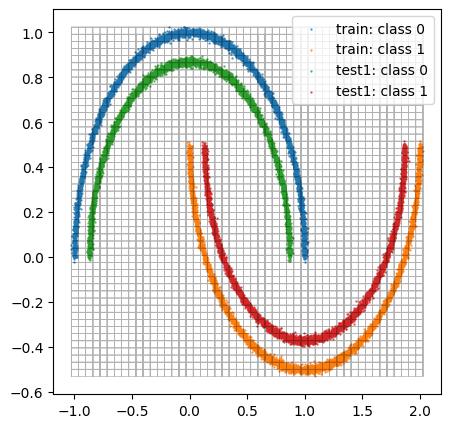

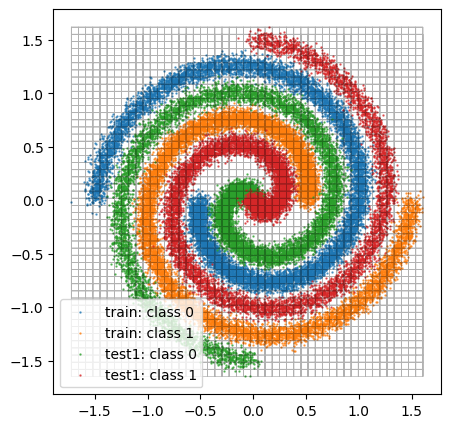

In [36]:
for dataset in [moons, spirals]:
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    x_train, y_train, x_test1, y_test1 = dataset['x_train'], dataset['y_train'], dataset['x_test1'], dataset['y_test1']
    ax1.plot(dataset['meshgrid'][:,0], dataset['meshgrid'][:,1], c="black", alpha=.3, linewidth=.5)
    ax1.scatter(x_train[y_train==0,0], x_train[y_train==0,1], alpha=0.7, s=0.5, c='C0', label="train: class 0")
    ax1.scatter(x_train[y_train==1,0], x_train[y_train==1,1], alpha=0.7, s=0.5, c='C1', label="train: class 1")
    ax1.scatter(x_test1[y_test1==0,0], x_test1[y_test1==0,1], alpha=0.7, s=0.5, c='C2', label="test1: class 0")
    ax1.scatter(x_test1[y_test1==1,0], x_test1[y_test1==1,1], alpha=0.7, s=0.5, c='C3', label="test1: class 1")
    ax1.legend()
    fig.show()

### Euclidean distance between datasets

In [37]:
def nearest_neighbour_distance(xy1, xy2):
    # Euclidean distance matrix (broadcasting along newaxis)
    euc_dist_mat = np.sqrt(np.sum((xy1[:, np.newaxis, :] - xy2[np.newaxis, :, :]) ** 2, axis=-1))
    euc_dist_mat[euc_dist_mat == 0] = np.nan  # Set diagonal to NaNs
    return np.nanmin(euc_dist_mat, axis=-1)  # Minimum ignoring NaNs

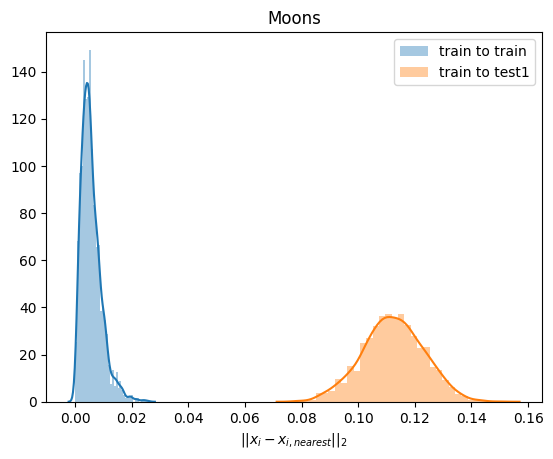

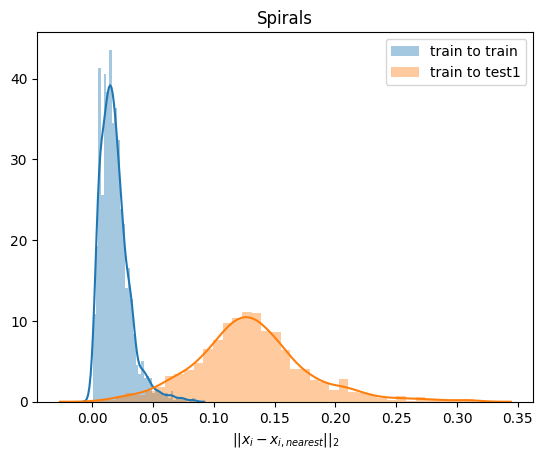

In [38]:
n_samples = 2000

nnd_train = nearest_neighbour_distance(moons['x_train'][:n_samples], moons['x_train'][:n_samples])
nnd_test1 = nearest_neighbour_distance(moons['x_train'][:n_samples], moons['x_test1'][:n_samples])
fig, ax = plt.subplots(1, 1)
seaborn.distplot(nnd_train, ax=ax, label='train to train')
seaborn.distplot(nnd_test1, ax=ax, label='train to test1')
ax.set_title('Moons')
ax.set_xlabel('$||x_i - x_{i, nearest}||_2$')
ax.legend()

nnd_train = nearest_neighbour_distance(spirals['x_train'][:n_samples], spirals['x_train'][:n_samples])
nnd_test1 = nearest_neighbour_distance(spirals['x_train'][:n_samples], spirals['x_test1'][:n_samples])
fig, ax = plt.subplots(1, 1)
seaborn.distplot(nnd_train, ax=ax, label='train to train')
seaborn.distplot(nnd_test1, ax=ax, label='train to test1')
ax.set_title('Spirals')
ax.set_xlabel('$||x_i - x_{i, nearest}||_2$')
ax.legend();

## Load models

In [208]:
def load_models(run_ids):
    models = dict()
    for model_abbr, run_id in run_ids.items():
        run_id = str(run_id)

        model = vari.models.HierarchicalVariationalAutoencoder
        # Load the saved kwargs
        kwargs = torch.load(
            os.path.join(experiments_dir, run_id, 'model_kwargs.pkl'),
            map_location=torch.device('cpu')
        )
        model = model(**kwargs)

        try:
            model.load_state_dict(torch.load(
                os.path.join(experiments_dir, run_id, 'model_state_dict.pkl'),
                map_location=torch.device('cpu')
            ))
            models[model_abbr] = model
            print(f'Loaded ID {run_id} {model_abbr.upper()} ')
        except Exception as exc:
            print(f'Failed loading {model_abbr.upper()} ID {run_id}')
            print(exc)
            models[model_abbr] = None
    return models

In [209]:
print('Moons')
models_moons = load_models(run_ids_moons)
print('Spirals')
models_spirals = load_models(run_ids_spirals)

Moons
Loaded ID 6741 VAE 1L 1IS Σ=0.01 BS=256 
Loaded ID 6740 VAE 2L 1IS Σ=0.01 BS=256 
Spirals
Loaded ID 6619 VAE1L 
Loaded ID 6625 VAE3L 


## Visualize latent space

In [62]:
constant_cmap = get_constant_colormap((0.2, 0.2, 0.2))

def plot_vectors_and_mesh(vectors, mesh=None, fig=None, ax=None, figsize=(20, 20), color='C0', alpha=0.4, label='train', label_ids=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
    
    if mesh is not None:
        ax.plot(mesh[:,0], mesh[:,1], c='black', alpha=.2, linewidth=.5)
        ax.scatter(mesh[:,0], mesh[:,1], c=[(.8, .8, .8, .8)], alpha=.5, s=5.)
    if label_ids is not None:
        for i in np.unique(label_ids):
            ax.scatter(vectors[label_ids==i, 0], vectors[label_ids==i, 1], c=f'C{i}', alpha=alpha, label=f"{label}:class{i}")
    else:
        ax.scatter(vectors[:,0], vectors[:,1], c=color, alpha=alpha, label=label)
    #ax1.scatter(vae_qz_mu_x2[:,0], vae_qz_mu_x2[:,1], c=[test1_0], alpha=0.4, label="test1")
    # ax1.axis('off')
    ax.legend()
    return fig, ax

### Moons

In [63]:
dataset = moons
models = models_moons

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

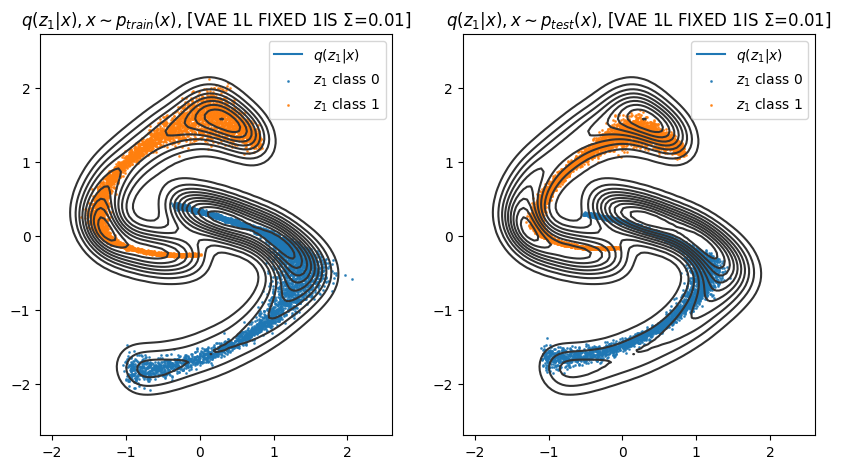

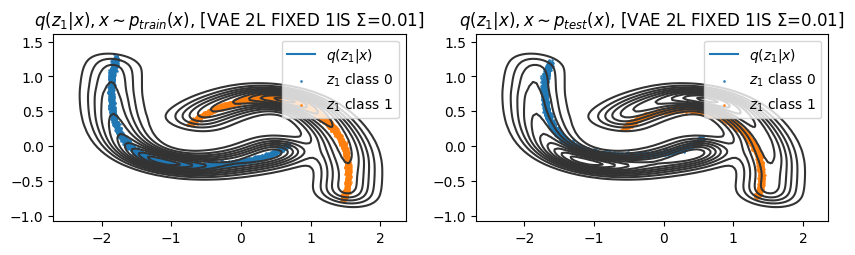

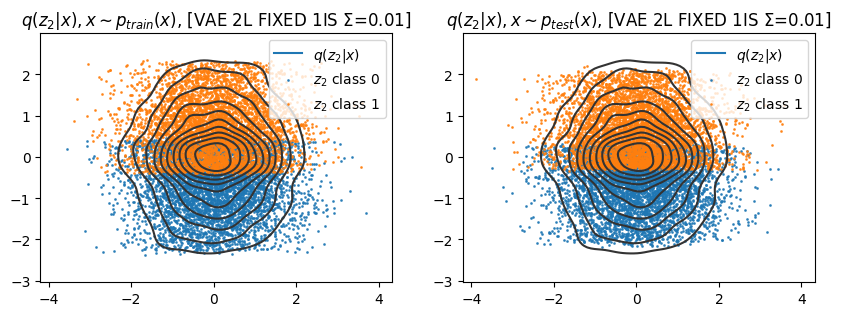

In [210]:
for abbr, model in models.items():
    with torch.no_grad():
        latents_train = model.encode(torch.FloatTensor(x_train))
        latents_test1 = model.encode(torch.FloatTensor(x_test1))
        latents_meshg = model.encode(torch.FloatTensor(meshgrid))

    for i_layer, name in enumerate(latents_train.keys(), start=1):
        qz_train = latents_train[name][0].squeeze()
        qz_mu_train = latents_train[name][1].mean.squeeze()

        qz_test1 = latents_test1[name][0].squeeze()
        qz_mu_test1 = latents_test1[name][1].mean.squeeze()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
        
        ax1.set_title(f'$q(z_{i_layer}|x), x\sim p_{{train}}(x)$, [{abbr.upper()}]')
        for c in set(y_train):
            ax1.scatter(qz_train[y_train==c, 0].numpy(),
                        qz_train[y_train==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax1)
        ax1.set_aspect('equal')
        ax1.legend()
        
        ax2.set_title(f'$q(z_{i_layer}|x), x\sim p_{{test}}(x)$, [{abbr.upper()}]')
        for c in set(y_test1):
            ax2.scatter(qz_test1[y_test1==c, 0].numpy(),
                        qz_test1[y_test1==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax2)
        ax2.set_aspect('equal')
        ax2.legend()

In [ ]:
for abbr, model in models.items():
    with torch.no_grad():
        latents_train = model.encode(torch.FloatTensor(x_train))
        latents_test1 = model.encode(torch.FloatTensor(x_test1))
        latents_meshg = model.encode(torch.FloatTensor(meshgrid))

    for i_layer, name in enumerate(latents_train.keys(), start=1):
        qz_x_train = latents_train[name][0].squeeze()
        qz_mu_x_train = latents_train[name][1].mean.squeeze()
        qz_mesh = latents_meshg[name][0].squeeze()
        qz_mu_mesh = latents_meshg[name][1].mean.squeeze()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
        plot_vectors_and_mesh(qz_mu_x_train, qz_mu_mesh, label_ids=y_train, ax=ax1)
        plot_vectors_and_mesh(qz_x_train, qz_mesh, label_ids=y_train, ax=ax2)
        ax1.set_title(f'{abbr.upper()} µ')
        ax2.set_title(f'{abbr.upper()} z ~ q_{i_layer}(z|x)')
        plt.show()

### Spirals

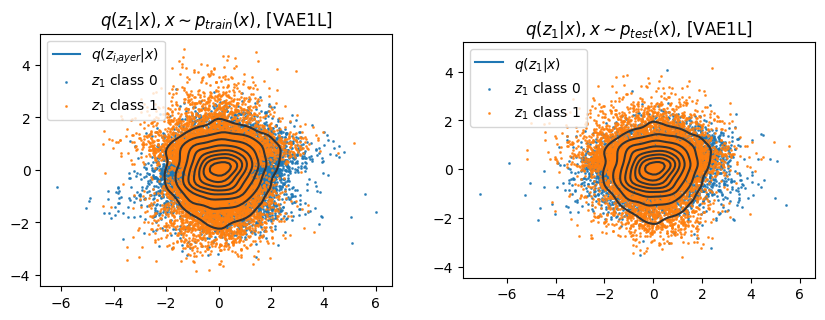

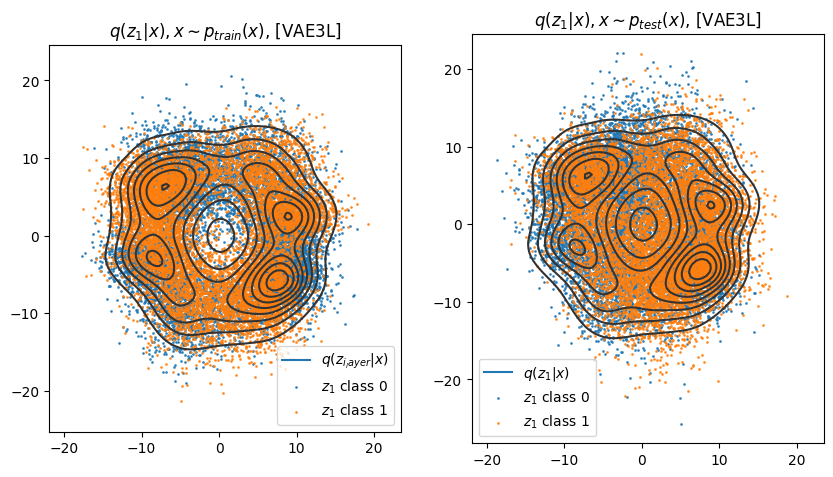

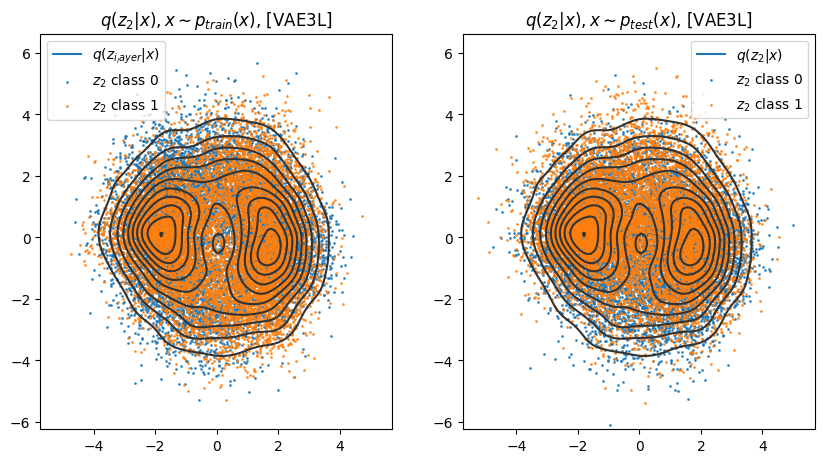

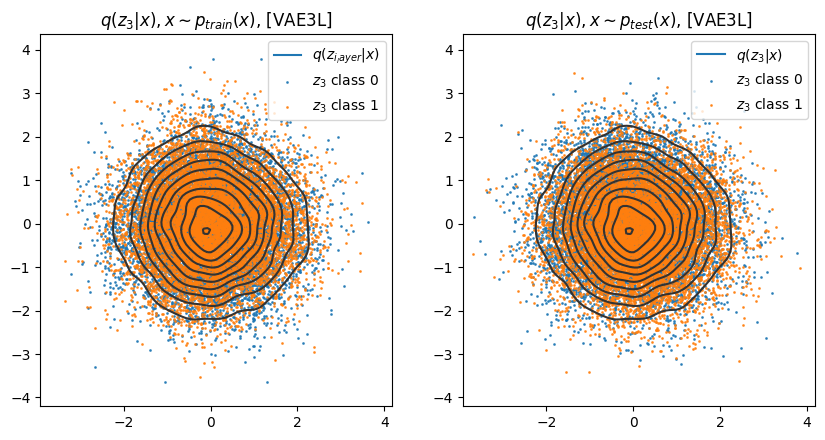

In [19]:
dataset = spirals
models = models_spirals

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

for abbr, model in models.items():
    with torch.no_grad():
        latents_train = model.encode(torch.FloatTensor(x_train))
        latents_test1 = model.encode(torch.FloatTensor(x_test1))
        latents_meshg = model.encode(torch.FloatTensor(meshgrid))

    for i_layer, name in enumerate(latents_train.keys(), start=1):
        qz_train = latents_train[name][0].squeeze()
        qz_mu_train = latents_train[name][1].mean.squeeze()

        qz_test1 = latents_test1[name][0].squeeze()
        qz_mu_test1 = latents_test1[name][1].mean.squeeze()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
        
        ax1.set_title(f'$q(z_{i_layer}|x), x\sim p_{{train}}(x)$, [{abbr.upper()}]')
        for c in set(y_train):
            ax1.scatter(qz_train[y_train==c, 0].numpy(),
                        qz_train[y_train==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label='$q(z_{i_layer}|x)$', ax=ax1)
        ax1.set_aspect('equal')
        ax1.legend()
        
        ax2.set_title(f'$q(z_{i_layer}|x), x\sim p_{{test}}(x)$, [{abbr.upper()}]')
        for c in set(y_test1):
            ax2.scatter(qz_test1[y_test1==c, 0].numpy(),
                        qz_test1[y_test1==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax2)
        ax2.set_aspect('equal')
        ax2.legend()

In [ ]:
for abbr, model in models.items():
    with torch.no_grad():
        latents_train = model.encode(torch.FloatTensor(x_train))
        latents_test1 = model.encode(torch.FloatTensor(x_test1))
        latents_meshg = model.encode(torch.FloatTensor(meshgrid))

    for i_layer, name in enumerate(latents_train.keys(), start=1):
        qz_x_train = latents_train[name][0].squeeze()
        qz_mu_x_train = latents_train[name][1].mean.squeeze()
        qz_mesh = latents_meshg[name][0].squeeze()
        qz_mu_mesh = latents_meshg[name][1].mean.squeeze()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
        plot_vectors_and_mesh(qz_mu_x_train, qz_mu_mesh, label_ids=y_train, ax=ax1)
        plot_vectors_and_mesh(qz_x_train, qz_mesh, label_ids=y_train, ax=ax2)
        ax1.set_title(f'{abbr.upper()} µ')
        ax2.set_title(f'{abbr.upper()} z ~ q_{i_layer}(z|x)')
        plt.show()

## Visualize reconstruction

AxesSubplot(0.125,0.11;0.352273x0.77) VAE 1L 1IS σ=0.01 BS=256
AxesSubplot(0.547727,0.11;0.352273x0.77) VAE 2L 1IS σ=0.01 BS=256


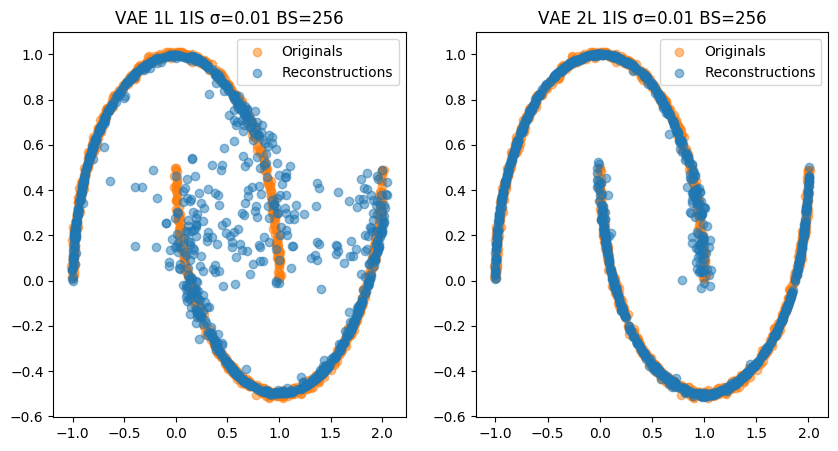

In [211]:
dataset = moons
models = models_moons

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 1000
n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5 * n_rows))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    print(ax, abbr)
    x_originals = torch.FloatTensor(x_train[:n_samples, :])
    with torch.no_grad():
        px_reconstructions = model(x_originals)
        
    plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_reconstructions.mean.squeeze(), alpha=0.5, label='Reconstructions', ax=ax)
    ax.set_title(abbr)

AxesSubplot(0.125,0.11;0.352273x0.77) VAE 1L 1IS σ=0.01 BS=256
AxesSubplot(0.547727,0.11;0.352273x0.77) VAE 2L 1IS σ=0.01 BS=256


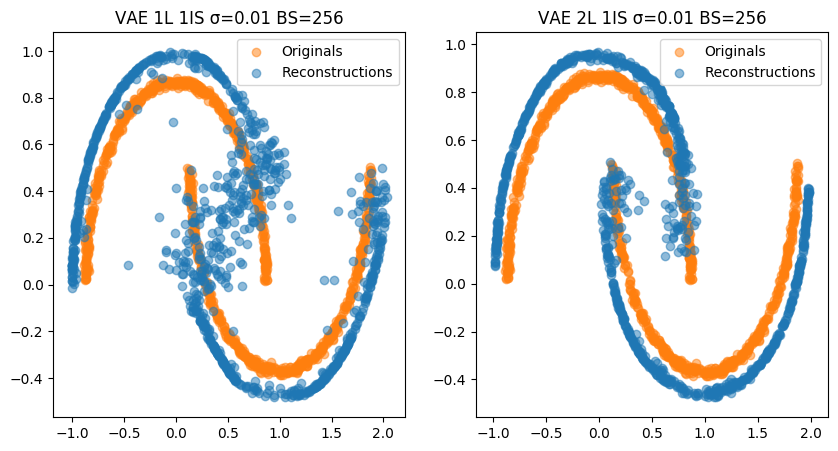

In [212]:
dataset = moons
models = models_moons

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 1000
n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5 * n_rows))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    print(ax, abbr)
    x_originals = torch.FloatTensor(x_test1[:n_samples, :])
    with torch.no_grad():
        px_reconstructions = model(x_originals)
        
    plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_reconstructions.mean.squeeze(), alpha=0.5, label='Reconstructions', ax=ax)
    ax.set_title(abbr)

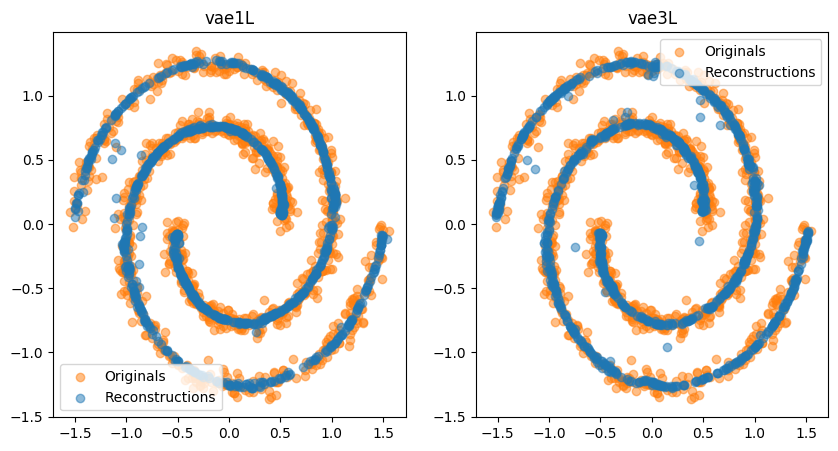

In [443]:
dataset = spirals
models = models_spirals

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 1000
n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    x_originals = torch.FloatTensor(x_train[:n_samples, :])
    with torch.no_grad():
        px_reconstructions = model(x_originals)
        
    plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_reconstructions.mean.squeeze(), alpha=0.5, label='Reconstructions', ax=ax)
    ax.set_title(abbr)

## Visualize sampling

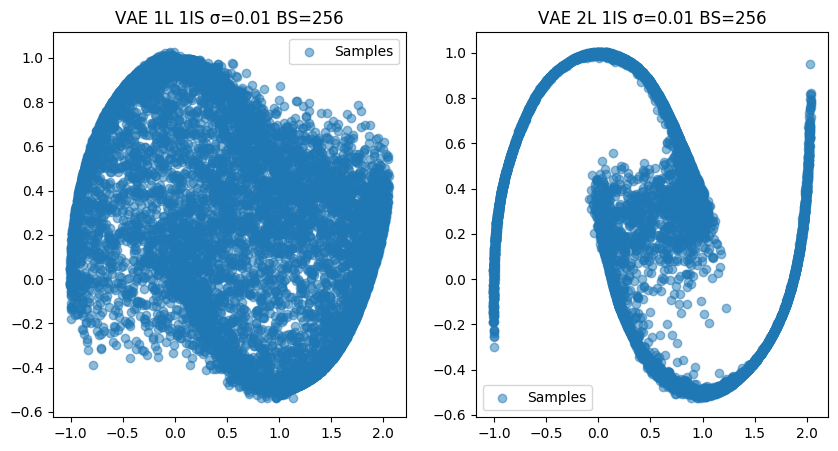

In [213]:
dataset = moons
models = models_moons

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 10000
p_z_samples = torch.randn((n_samples, 2))

n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5*n_rows))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    #x_originals = torch.FloatTensor(x_test1[:n_samples, :])
    
    with torch.no_grad():
        px_samples = model.generate(z=p_z_samples)
        
    #plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_samples.mean.squeeze(), alpha=0.5, label='Samples', ax=ax)
    ax.set_title(abbr)

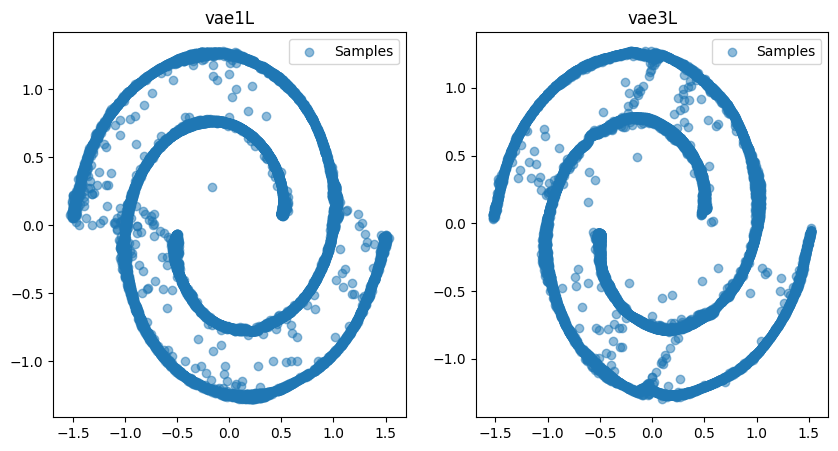

In [999]:
dataset = spirals
models = models_spirals

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 10000
p_z_samples = torch.randn((n_samples, 2))

n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    #x_originals = torch.FloatTensor(x_train[:n_samples, :])

    with torch.no_grad():
        px_samples = model.generate(z=p_z_samples)
        
    #plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_samples.mean.squeeze(), alpha=0.5, label='Samples', ax=ax)
    ax.set_title(abbr)

## Visualize ELBO

In [906]:
def compute_elbo_grid(model, x_lim, y_lim, importance_samples=10, zoom=0, nx=500, ny=500):
    (x_min, x_max), (y_min, y_max) = x_lim, y_lim
    x = np.linspace(x_min - np.abs(x_min * zoom), x_max + np.abs(x_max * zoom), nx)
    y = np.linspace(y_min - np.abs(y_min * zoom), y_max + np.abs(y_max * zoom), ny)
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    zv = np.zeros(xv.shape)
    with torch.no_grad():
        for j in tqdm.tqdm(range(x.shape[0])):
            inp = np.append(xv[:, j:j+1], yv[:, j:j+1], axis=1)
            inp = torch.FloatTensor(inp)
            elbo, kl, likelihood = model.elbo(inp, importance_samples=importance_samples)
            zv[:, j] = elbo.flip(0)
    return zv

In [907]:
elbo_min_clip = -100

In [909]:
model = models_moons[list(models_moons.keys())[0]]

vae_zv = dict()
vae_zv[1] = compute_elbo_grid(model, (x_min, x_max), (y_min, y_max), zoom=1, importance_samples=10)
vae_zv[10] = compute_elbo_grid(model, (x_min, x_max), (y_min, y_max), zoom=10, importance_samples=10)

100%|██████████| 500/500 [00:07<00:00, 69.75it/s] 


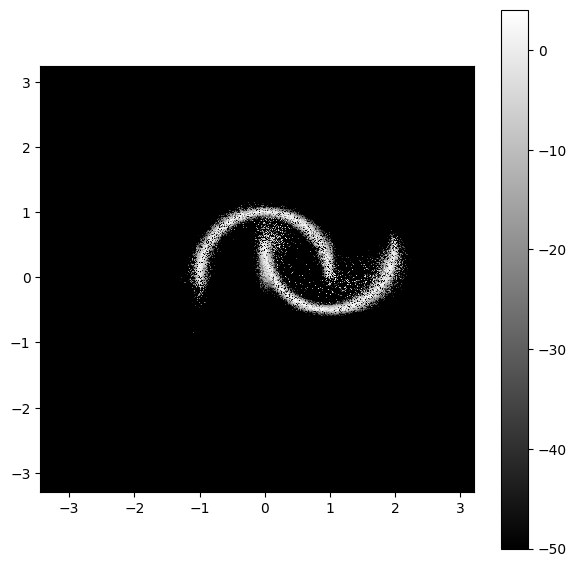

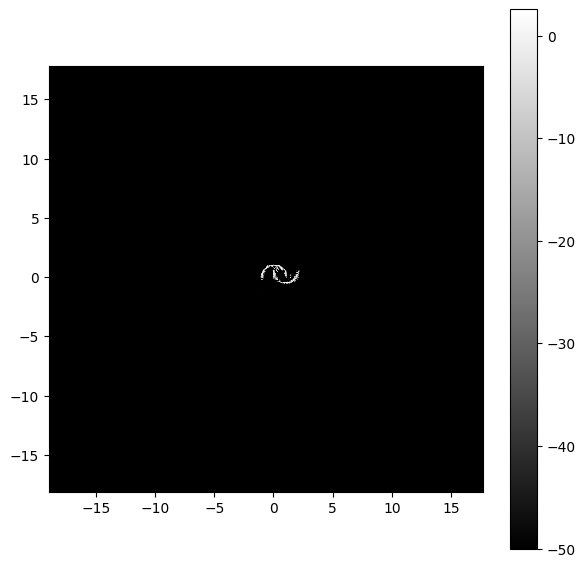

In [910]:
for zoom, zv in vae_zv.items():
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    plt.imshow(zv.clip(min=elbo_min_clip), mpl.cm.get_cmap('binary_r'), extent=(
        x_min - np.abs(x_min * zoom),
        x_max + np.abs(x_max * zoom),
        y_min - np.abs(y_min * zoom),
        y_max + np.abs(y_max * zoom)
    ))
    plt.colorbar()
    ax1.axis(aspect='image');

In [28]:
vae_zv = dict()
vae_zv[1] = compute_elbo_grid(models_moons['vae2L'], (x_min, x_max), (y_min, y_max), zoom=1, importance_samples=10)
vae_zv[10] = compute_elbo_grid(models_moons['vae2L'], (x_min, x_max), (y_min, y_max), zoom=10, importance_samples=10)

100%|██████████| 500/500 [00:05<00:00, 91.16it/s] 


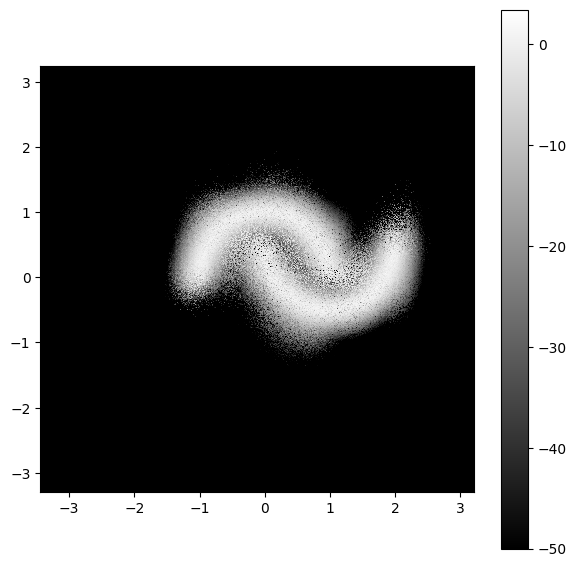

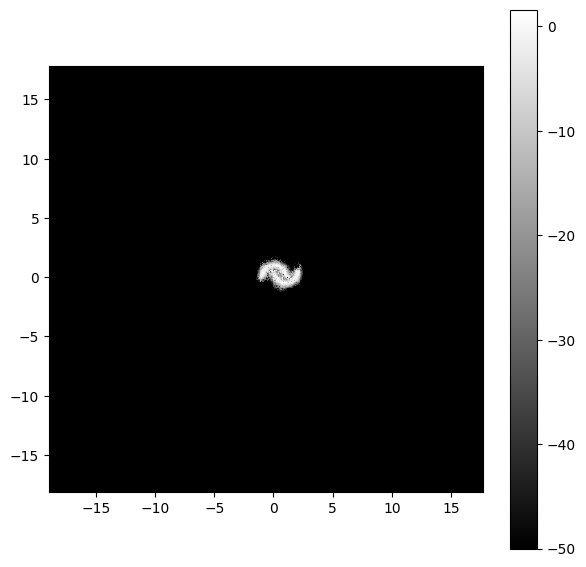

In [29]:
for zoom, zv in vae_zv.items():
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    plt.imshow(zv.clip(min=elbo_min_clip), mpl.cm.get_cmap('binary_r'), extent=(
        x_min - np.abs(x_min * zoom),
        x_max + np.abs(x_max * zoom),
        y_min - np.abs(y_min * zoom),
        y_max + np.abs(y_max * zoom)
    ))
    plt.colorbar()
    ax1.axis(aspect='image');

## OOD detection based on ELBO

### Moons

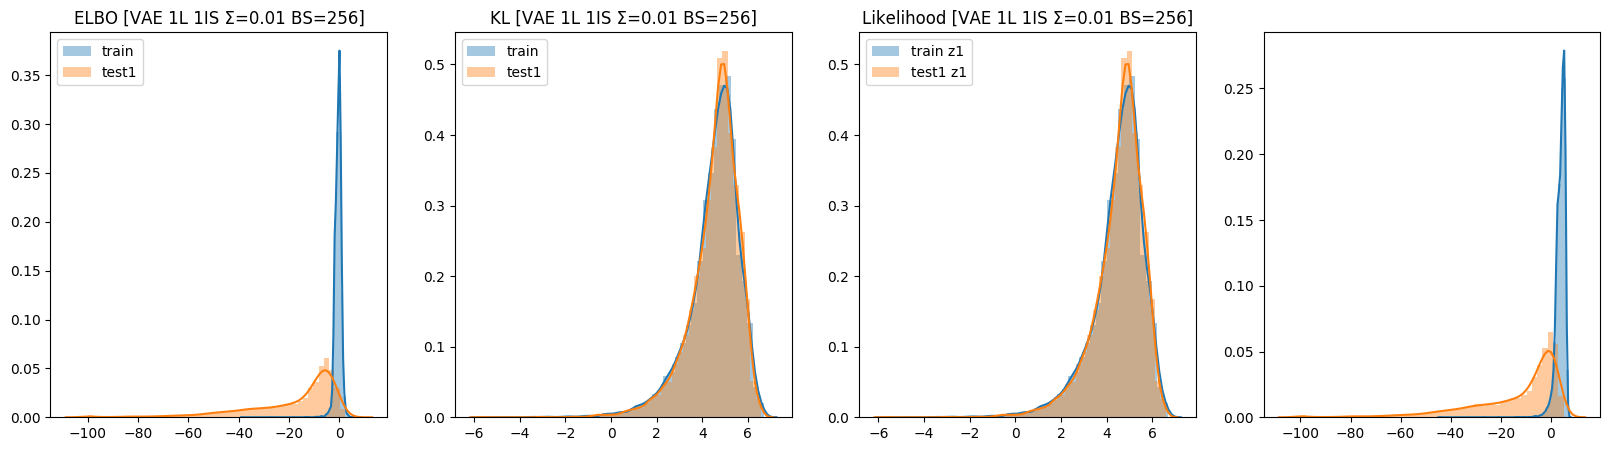

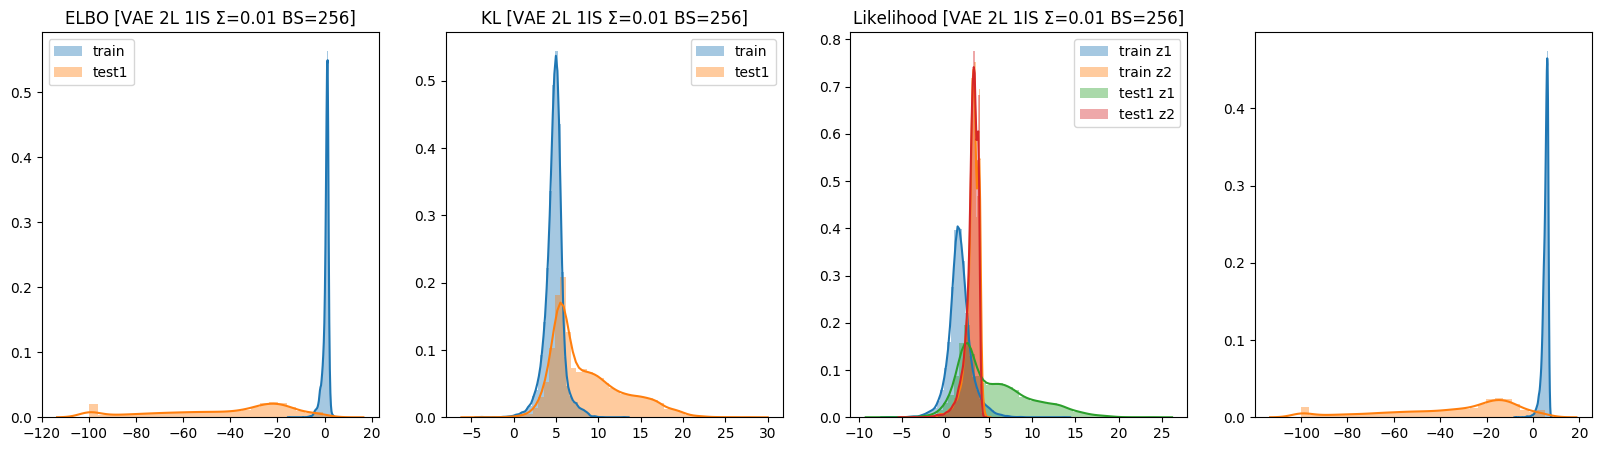

In [216]:
dataset = moons
models = models_moons

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
for abbr, model in models.items():
    with torch.no_grad():
        copy_latents = dict(z1=True, z2=True) if model.n_layers > 1 else None
        
        torch.manual_seed(0)
            
        elbo_train, likelihood_train, kl_train = model.elbo(torch.FloatTensor(x_train), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_train = model.kl_divergences
        elbo_test1, likelihood_test1, kl_test1 = model.elbo(torch.FloatTensor(x_test1), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_test1 = model.kl_divergences
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

    seaborn.distplot(elbo_train.clamp(-100), kde_kws={}, ax=ax1, label='train')
    seaborn.distplot(elbo_test1.clamp(-100), kde_kws={}, ax=ax1, label='test1')
    seaborn.distplot(kl_train, kde_kws={}, ax=ax2, label='train')
    seaborn.distplot(kl_test1, kde_kws={}, ax=ax2, label='test1')
    
    for latent_key, kl in kls_train.items():
        seaborn.distplot(kl, kde_kws={}, ax=ax3, label=f'train {latent_key}')
    for latent_key, kl in kls_test1.items():
        seaborn.distplot(kl, kde_kws={}, ax=ax3, label=f'test1 {latent_key}')

    seaborn.distplot(likelihood_train.clamp(-100), kde_kws={}, ax=ax4, label='train')
    seaborn.distplot(likelihood_test1.clamp(-100), kde_kws={}, ax=ax4, label='test1')

    ax1.set_title(f'ELBO [{abbr.upper()}]')
    ax2.set_title(f'KL [{abbr.upper()}]')
    ax3.set_title(f'Likelihood [{abbr.upper()}]')
    ax1.legend()
    ax2.legend()
    ax3.legend()

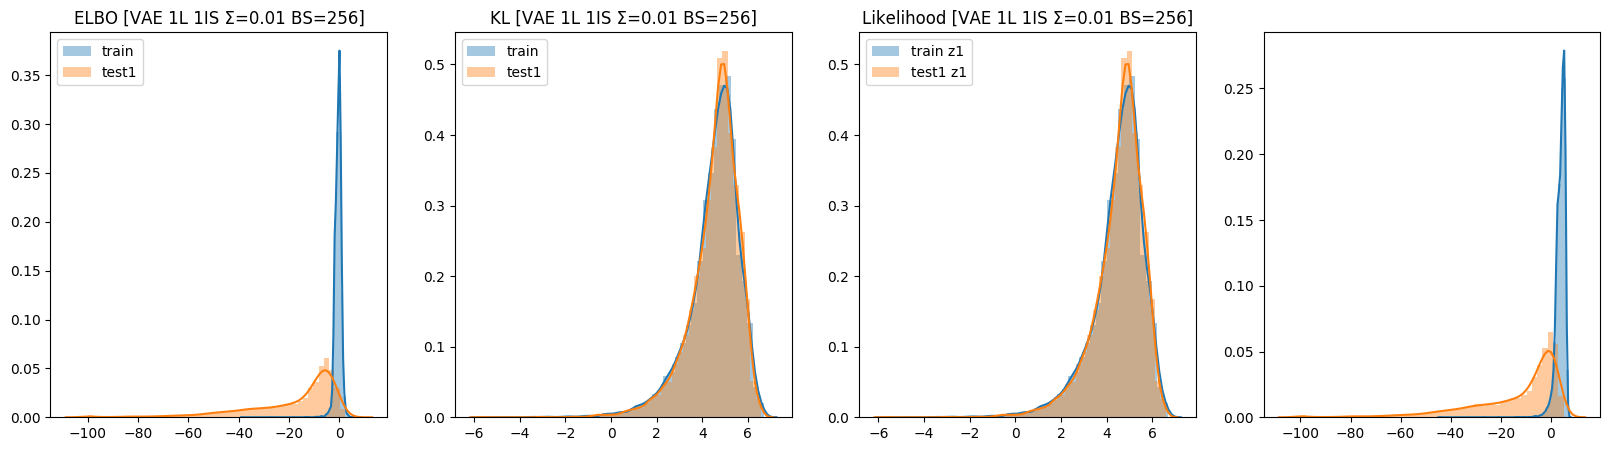

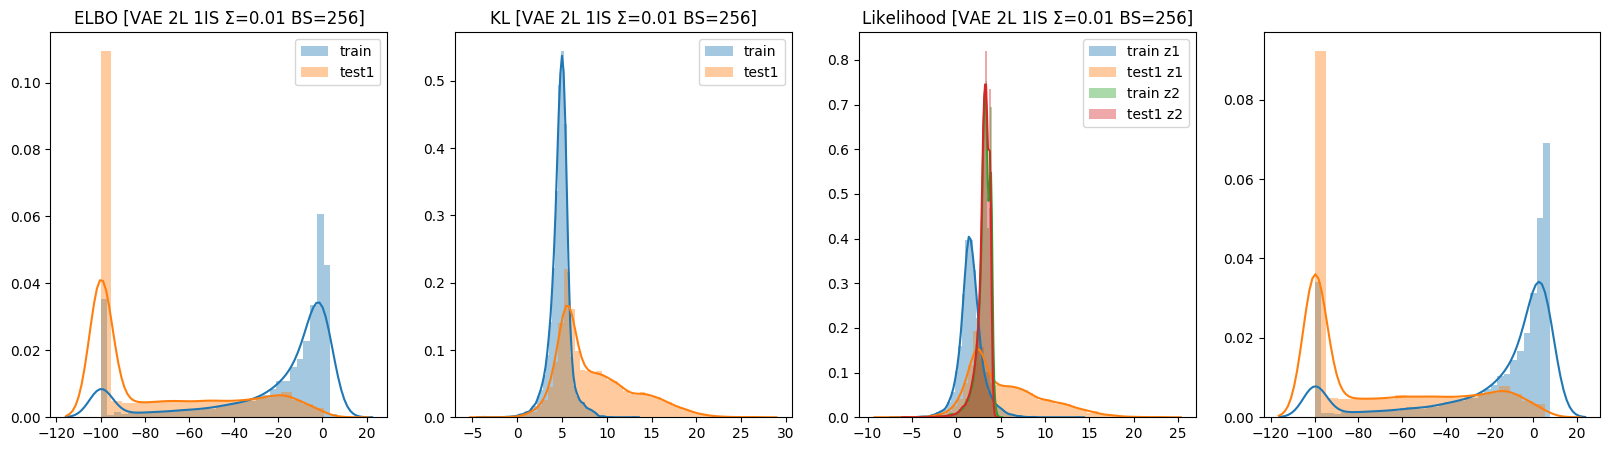

In [219]:
dataset = moons
models = models_moons

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
for abbr, model in models.items():
    with torch.no_grad():
        copy_latents = dict(z1=False, z2=True) if model.n_layers > 1 else None
        
        torch.manual_seed(0)
            
        elbo_train, likelihood_train, kl_train = model.elbo(torch.FloatTensor(x_train), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_train = model.kl_divergences
        elbo_test1, likelihood_test1, kl_test1 = model.elbo(torch.FloatTensor(x_test1), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_test1 = model.kl_divergences
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

    seaborn.distplot(elbo_train.clamp(-100), kde_kws={}, ax=ax1, label='train')
    seaborn.distplot(elbo_test1.clamp(-100), kde_kws={}, ax=ax1, label='test1')
    seaborn.distplot(kl_train, kde_kws={}, ax=ax2, label='train')
    seaborn.distplot(kl_test1, kde_kws={}, ax=ax2, label='test1')
    
    for (latent_key, _kl_train), (_, _kl_test1) in zip(kls_train.items(), kls_test1.items()):
        seaborn.distplot(_kl_train, kde_kws={}, ax=ax3, label=f'train {latent_key}')
        seaborn.distplot(_kl_test1, kde_kws={}, ax=ax3, label=f'test1 {latent_key}')

    seaborn.distplot(likelihood_train.clamp(-100), kde_kws={}, ax=ax4, label='train')
    seaborn.distplot(likelihood_test1.clamp(-100), kde_kws={}, ax=ax4, label='test1')

    ax1.set_title(f'ELBO [{abbr.upper()}]')
    ax2.set_title(f'KL [{abbr.upper()}]')
    ax3.set_title(f'Likelihood [{abbr.upper()}]')
    ax1.legend()
    ax2.legend()
    ax3.legend()

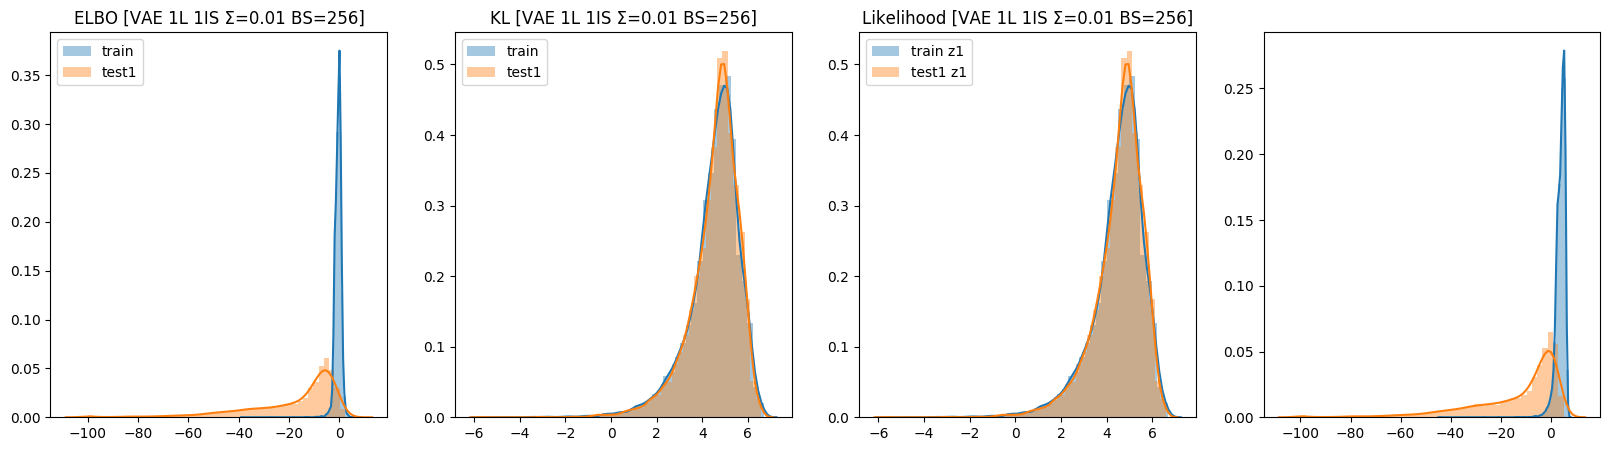

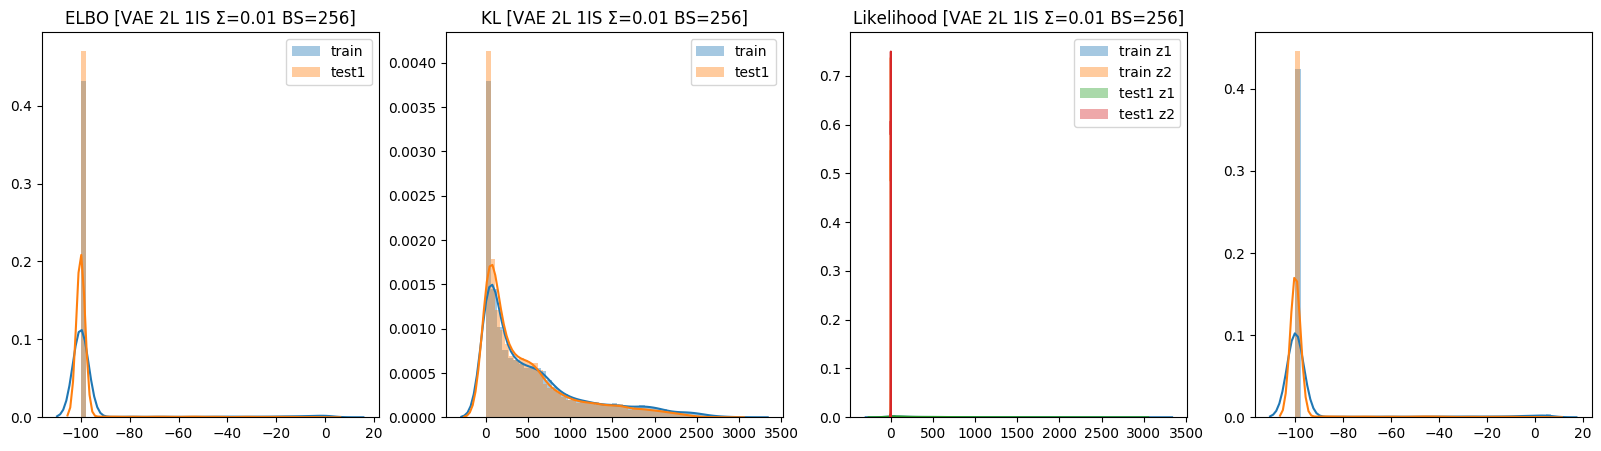

In [218]:
dataset = moons
models = models_moons

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
for abbr, model in models.items():
    with torch.no_grad():
        copy_latents = dict(z1=False, z2=False) if model.n_layers > 1 else None
        
        torch.manual_seed(0)
            
        elbo_train, likelihood_train, kl_train = model.elbo(torch.FloatTensor(x_train), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_train = model.kl_divergences
        elbo_test1, likelihood_test1, kl_test1 = model.elbo(torch.FloatTensor(x_test1), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_test1 = model.kl_divergences
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

    seaborn.distplot(elbo_train.clamp(-100), kde_kws={}, ax=ax1, label='train')
    seaborn.distplot(elbo_test1.clamp(-100), kde_kws={}, ax=ax1, label='test1')
    seaborn.distplot(kl_train, kde_kws={}, ax=ax2, label='train')
    seaborn.distplot(kl_test1, kde_kws={}, ax=ax2, label='test1')
    
    for latent_key, kl in kls_train.items():
        seaborn.distplot(kl, kde_kws={}, ax=ax3, label=f'train {latent_key}')
    for latent_key, kl in kls_test1.items():
        seaborn.distplot(kl, kde_kws={}, ax=ax3, label=f'test1 {latent_key}')

    seaborn.distplot(likelihood_train.clamp(-100), kde_kws={}, ax=ax4, label='train')
    seaborn.distplot(likelihood_test1.clamp(-100), kde_kws={}, ax=ax4, label='test1')

    ax1.set_title(f'ELBO [{abbr.upper()}]')
    ax2.set_title(f'KL [{abbr.upper()}]')
    ax3.set_title(f'Likelihood [{abbr.upper()}]')
    ax1.legend()
    ax2.legend()
    ax3.legend()

### Spirals

AssertionError: Specify for each latent whether to copy.

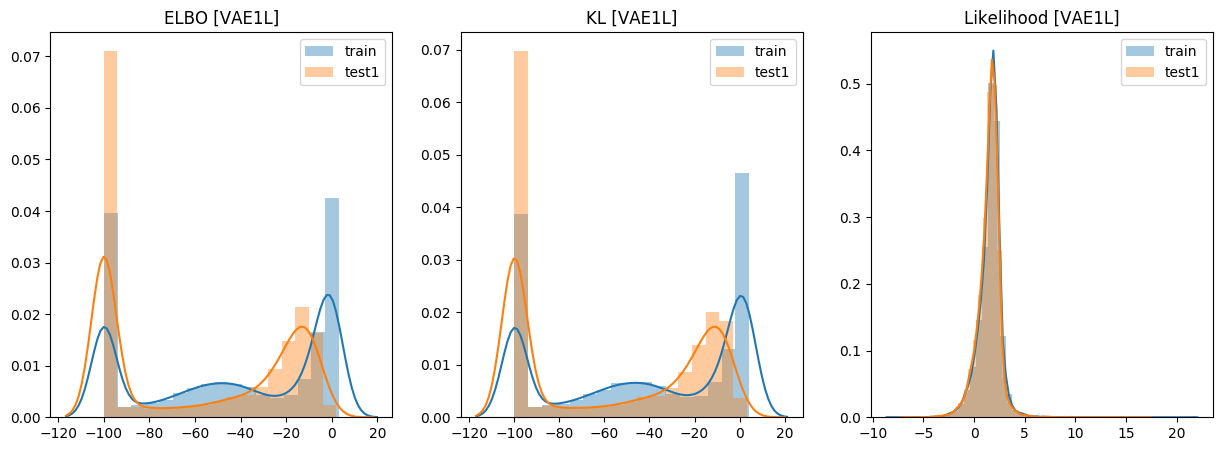

In [80]:
dataset = spirals
models = models_spirals

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
for abbr, model in models.items():
    with torch.no_grad():
        copy_latents = dict(z1=False, z2=False) if model.n_layers > 1 else None
        
        torch.manual_seed(0)
            
        elbo_train, kl_train, likelihood_train = model.elbo(torch.FloatTensor(x_train), importance_samples=1,
                                                            copy_latents=copy_latents)
        elbo_test1, kl_test1, likelihood_test1 = model.elbo(torch.FloatTensor(x_test1), importance_samples=1,
                                                            copy_latents=copy_latents)
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

    seaborn.distplot(elbo_train.clamp(-100), kde_kws={}, ax=ax1, label='train')
    seaborn.distplot(elbo_test1.clamp(-100), kde_kws={}, ax=ax1, label='test1')
    seaborn.distplot(kl_train.clamp(-100), kde_kws={}, ax=ax2, label='train')
    seaborn.distplot(kl_test1.clamp(-100), kde_kws={}, ax=ax2, label='test1')
    seaborn.distplot(likelihood_train.clamp(-100), kde_kws={}, ax=ax3, label='train')
    seaborn.distplot(likelihood_test1.clamp(-100), kde_kws={}, ax=ax3, label='test1')

    ax1.set_title(f'ELBO [{abbr.upper()}]')
    ax2.set_title(f'KL [{abbr.upper()}]')
    ax3.set_title(f'Likelihood [{abbr.upper()}]')
    ax1.legend()
    ax2.legend()
    ax3.legend()

## Animate generation during training

In [41]:
import matplotlib.pyplot as plt
import natsort

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [42]:
from IPython import embed
def get_substring_digit(s):
    return int(''.join([ss for ss in s if ss.isdigit()]))

def get_training_samples(run_id):
    npys = dict()
    for f in os.listdir(os.path.join(experiments_dir, str(run_id))):
        if f.endswith('.npy'):
            epoch = get_substring_digit(f)
            npys[epoch] = np.load(os.path.join(experiments_dir, str(run_id), f))
    return npys

In [43]:
run_id = '6714'
npys = get_training_samples(run_id)

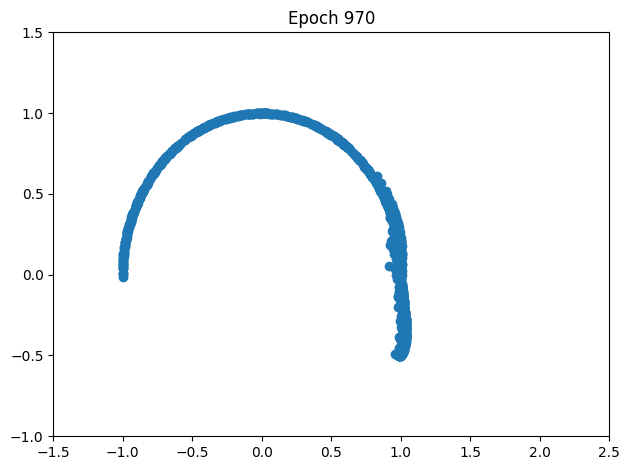

In [44]:
fig, ax = plt.subplots()
fig.set_tight_layout(True)
scat = ax.scatter([], [])

def init():
    return (scat, )

def update(i):
    scat.set_offsets(npys[i])
    ax.set_xlim([-1.5, 2.5])
    ax.set_ylim([-1, 1.5])
    ax.set_title(f'Epoch {i}')
    return (scat, )
    
    
epochs_sorted = natsort.natsorted(npys.keys())
anim = FuncAnimation(fig,
                     update,
                     frames=[*epochs_sorted[:1]*10, *epochs_sorted, *epochs_sorted[-1:]*10], 
                     init_func=init,
                     interval=150,
                     blit=True)

HTML(anim.to_html5_video())

In [679]:
anim.save(f'training_samples_{run_id}.mp4', codec='h264')